# Example - US Retail Sales¶
The US Retail Sales dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [33]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    "./us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

# The code you've provided reads a CSV file containing U.S. retail sales data, 
# selecting only the columns "Month" and the industries specified in the industries 
# list. It then converts the "Month" column into a date format with daily periods
# (to_period('D')) and reindexes the DataFrame to include only the specified 
# industries. Finally, the code wraps the DataFrame under a new column index labeled 
# "Sales," with a secondary level corresponding to the industry names.

# The None in the names=[None, 'Industries'] parameter is used to indicate that the first
# level of the column index should not have a specific name. The pd.concat function is 
# creating a new MultiIndex for the columns, where the first level corresponds to 'Sales', 
# and the second level corresponds to the industry names.

## None: This means that the first level of the MultiIndex does not have a name.
##'Industries': This names the second level of the MultiIndex as "Industries."

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

First let's use a linear regression model to learn the trend in each series. For demonstration, we'll use a quadratic (order 2) trend. (The code here is basically the same as that in previous lessons.) Though the fit isn't perfect, it will be enough for our needs.

In [34]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)


X = dp.in_sample()  # features for the training data
X.head()

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0


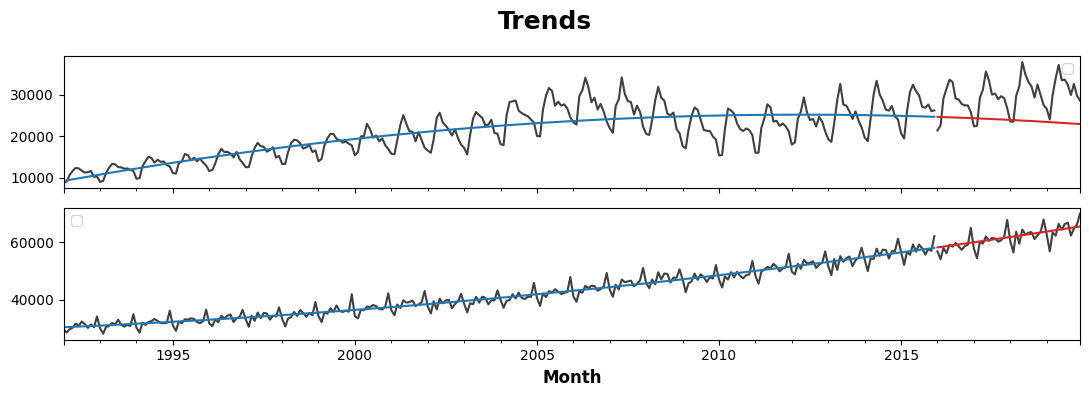

In [35]:
# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]


# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")



While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from wide format, with one time series per column, to long format, with series indexed by categories along rows.

In [36]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
display(retail.head())
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series
display(y.head())

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
Name: Sales, dtype: int64

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for 'Industries' into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [37]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')

# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12
display(X)

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]



,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3
...,...,...
2019-10-01,1,10
2019-11-01,0,11
2019-11-01,1,11


Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
Name: Sales, dtype: int64

Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [38]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

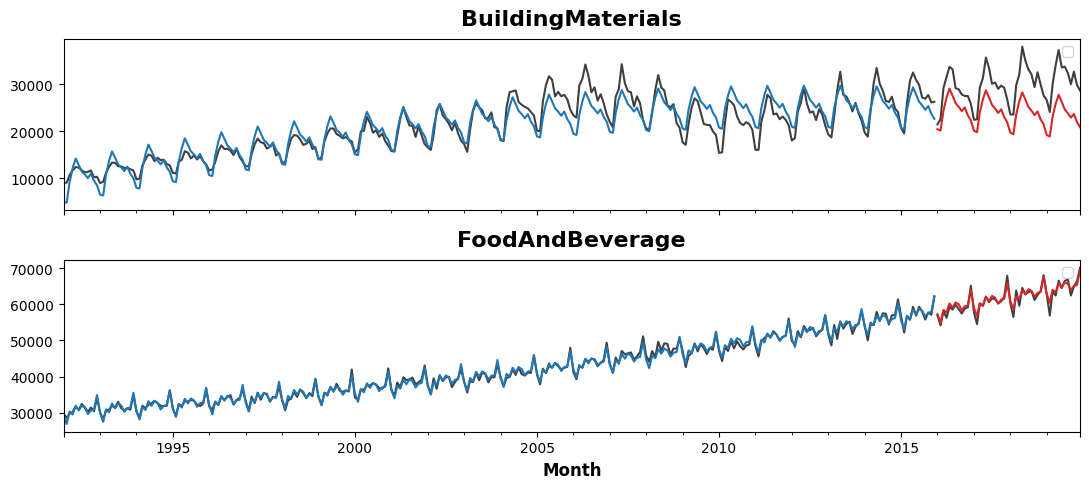

In [39]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])